In [49]:
import cv2 as cv2
import os
import matplotlib.pyplot as plt
import easyocr
import pyocr
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import sys
import re

path = "/Users/satoshan/Library/CloudStorage/Box-Box/scan_org_charts/"
path_2010 = path + "2010"

/Users/satoshan/Library/CloudStorage/Box-Box/scan_org_charts/2010/image00006.jpg


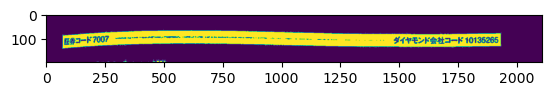

['7007', '10135265']


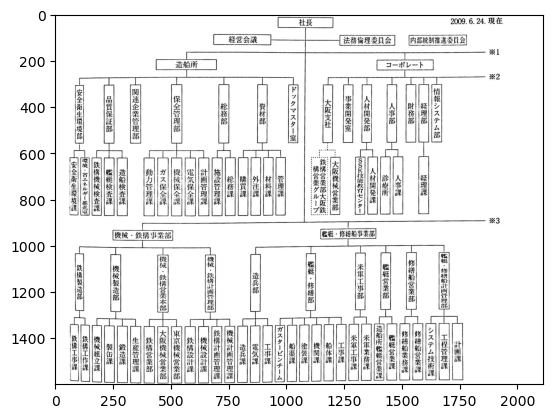

In [50]:
# Choose 2010 of "三井造船"
files = os.listdir(path_2010)
files = [f for f in files if os.path.isfile(os.path.join(path_2010, f))]
files.sort()
file = os.path.join(path_2010, files[5])

# img 
print(file)
img = cv2.imread(file)

# code detection ocr
header = img[50:250, 10:-10]
gray_image = cv2.cvtColor(header, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 245, 255, cv2.THRESH_BINARY)
gray_image_inv = cv2.bitwise_not(binary_image)
plt.imshow(gray_image_inv)
plt.show()

pil_image = Image.fromarray(gray_image_inv)
tools = pyocr.get_available_tools()
tool = tools[0]
txt = tool.image_to_string(
    pil_image,
    lang="jpn",
    builder=pyocr.builders.TextBuilder(tesseract_layout=6)
)
filtered_text = re.findall(r'\d+', txt)
print(filtered_text)

# cutting header and edges
header_size = 480
cropped_image = img[header_size:, 10:-10]

# cutting footer
# make figure biniary
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
gray_image_inv = cv2.bitwise_not(gray_image)

# footer detection
row_sums = np.sum(gray_image_inv, axis=1) 
threshold = 100
empty_row_threshold = 30

empty_row_count = 0
footer_start = None
for i, row_sum in enumerate(row_sums):
    if row_sum < threshold:
        empty_row_count += 1
    else:
        empty_row_count = 0
    if empty_row_count >= empty_row_threshold:
        footer_start = i - empty_row_threshold + 1
        break

if footer_start is not None:
    final_image = cropped_image[:footer_start, :]
else:
    final_image = cropped_image

plt.imshow(final_image)
plt.show()

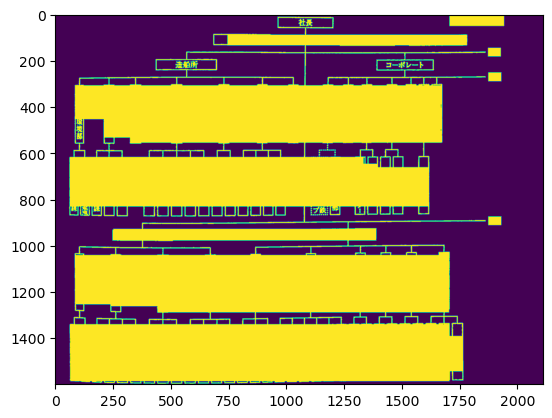

In [46]:
gray_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
denoised_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
_, binary_image = cv2.threshold(denoised_image, 245, 255, cv2.THRESH_BINARY)
gray_image_inv = cv2.bitwise_not(binary_image)
gray_image_inv_copy = gray_image_inv.copy()
pil_image = Image.fromarray(gray_image_inv_copy)
text_boxes = tool.image_to_string(
    pil_image, 
    lang="jpn", 
    builder=pyocr.builders.LineBoxBuilder(tesseract_layout=6)
)

for box in text_boxes:
    (x1, y1) = box.position[0]
    (x2, y2) = box.position[1]
    
    padding = 5

    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(gray_image_inv.shape[1], x2 + padding)
    y2 = min(gray_image_inv.shape[0], y2 + padding)

    cv2.rectangle(gray_image_inv_copy, (x1, y1), (x2, y2), (255, 255, 255), -1)

plt.imshow(gray_image_inv_copy)
plt.show()